# Ferdinand Beaman Phase 4 Project

For this project, I attempted to take about ten thousand curated tweets categorize them by their positivity. Thankfully, they have already been labeled by the helpful people here: https://data.world/crowdflower/brands-and-product-emotions

My hypothetical business problem: The organizers of South by Southwest contacted me to collect public opinion about what they did right at a given year's festival in order for them to know what to emphasize next time.

I considered building a ternary instead of binary classifier (positive, neutral, and then also negative), but considering both the small size of the third class and my own time remaining in the program, I decided against it.

There was a class imbalance (2:1), but my research suggests that it's only moderate and not strong enough for me to intervene. With that in mind and seeing no other reasons to have special sensitivity for false negatives/positives, I predominately used accuracy scores to rank models' performances. However, if there did happen to be some major issue with either recall/precision regarding the minority class, I would take that into account.

I went with a Naive Bayes classifier because it appears to be approximately as accurate as the more complex classifier while being significantly easier on both my computer and my mind.

Midway, I ran into an unexpected surprise: a message in Spanish. So I spent an embarrassingly long time trying to figure out how to manage non-English languages. I searched for messages that contained no English stopwords and/or messages that contained any stopwords in common languages (excluding stopwords in those languages that are also in the English list). Ultimately, it was all for naught. I realized that either the messages would be so rare as to be essentially thrown out by the process which means they're not worth deleting *or* the messages will be common enough to matter. With that whole subsection gone, this paragraph is mostly here in memoriam.

## Exploratory phase

As one might expect, here are the libraries I used and a preview of the database:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

import nltk
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('wordnet')
from nltk.collocations import *
import string
import re
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

[nltk_data] Downloading package wordnet to /Users/ferdi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
df = pd.read_csv("BrandsAndProductEmotions.csv", encoding='unicode_escape')
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


The words following "@" are probably useless, and nearly all of them will be removed by the tokenization process in the future. "Swxw" ends up being added to the stopwords list and the rest are mostly names which will be filtered out for being too rare.

My first edits were to the column names. Also, the last row in the DataFrame is definitely not made for human eyes so I'll just cut it right away.

In [3]:
df.columns = ["text", "product", "emotion"]
df.drop(df.index[9092], inplace = True)

Is there anything interesting from a macro level?

In [4]:
#Value counts for the two categorical columns
print("Emotion")
print(df.emotion.value_counts())
print("\nProducts")
print(df["product"].value_counts())

Emotion
No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: emotion, dtype: int64

Products
iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: product, dtype: int64


Here's a visualization of our target variable:

''

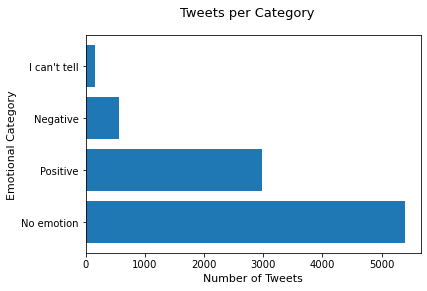

In [5]:
keys = ["No emotion", "Positive", "Negative", "I can't tell"]
values = [df["emotion"].value_counts()[0], df["emotion"].value_counts()[1],
         df["emotion"].value_counts()[2], df["emotion"].value_counts()[3]]
plt.barh(keys, values)
plt.suptitle("Tweets per Category", fontsize=13)
plt.xlabel("Number of Tweets", fontsize=11)
plt.ylabel("Emotional Category", fontsize=11)
;

The "Negative emotion" class has only about 10% of the entries of the neutral class, and only 6% overall. Obviously in a real world setting I wouldn't be able to retroactively adjust my business problem, but for ease's sake it was here that I decided to probably go with a binary classifier between "positive emotion" and "not positive emotion".

In [6]:
print(df.shape)
print("\n")
print(df.info())

(9092, 3)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 9092 entries, 0 to 9091
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     9091 non-null   object
 1   product  3291 non-null   object
 2   emotion  9092 non-null   object
dtypes: object(3)
memory usage: 284.1+ KB
None


2/3s of the entries are missing a product label. Also, somehow, one of the text entries is null. Suppose that's something I'll get used to the longer I work in the field.

In [7]:
#Before I forget, let me look at that null entry
df[df["text"].isnull()]

,text,product,emotion
6,NaN,NaN,No emotion toward brand or product


Predictably, this was useless.

In [8]:
df.drop(df.index[6], inplace = True)
df.reset_index(drop=True, inplace = True)

What about tweets just missing product labels? Below is an arbitrary sample.

In [9]:
df.iloc[9090]["text"]

'Some Verizon iPhone customers complained their time fell back an hour this weekend.  Of course they were the New Yorkers who attended #SXSW.'

Yeah, this is fairly generic. How did this end up here? My assumption is that the csv file is just made up of tweets that were scraped from a specific time, possibly even from a specific area if that's possible. 

The above tweet was also pretty emotionless. Are all of the ones with missing product labels equally drab?

In [10]:
df[df["product"].isnull()]["emotion"].value_counts()

No emotion toward brand or product    5296
Positive emotion                       306
I can't tell                           147
Negative emotion                        51
Name: emotion, dtype: int64

No, there are emotional statements in here. This seems to be *somewhat* similar to the rest of the dataset except for a big dropoff for positive tweets.

# Preprocessing

Before the more routine preprocessing tasks, there are two things I had to get out of the way: seeing if entries with NaN in the "emotion" column are worth keeping, and investigating the "I can't tell"s.

## Unclear Labels

Below are 10 sample messages from those with NaN as the product, presumably directed at nothing in particular:

In [11]:
null_prod_s = df[df["product"].isnull() == True].sample(n=10, random_state =2)
for i in range(10):
    print(null_prod_s["text"].iloc[i])
    print("\n")

RT Hiring marketers, designers, creatives, social media pros... Come see #Aquent booth 1415 #SXSW trade show. Might win iPad 2


RT @mention Full #SXSW #touchingstories presentation: {link}


RT @mention #SXSW Interactive Award: Music Category goes to &quot;Wilderness Downtown&quot;. Congrats shared with @mention @mention @mention #winning


One guy stakes out the Austin Apple popup shop at #SXSW for his #iPad 2 {link} #SXSWi


RT @mention RT @mention Google set to launch new social network #Circles today at #sxsw


hey @mention heard you're at #sxsw. Come by to the @mention grille and make your comic into a iPhone case? What do you say? :]


Too bad I don't have a _ button!
RT @mention I know its #SXSW time when I have an abnormal amount of app updates on my iPhone.


RT @mention &quot;my kids will not grow up thinking the New York Times and Google are in separate industries&quot; @mention #bvj #SXSW


packing for #sxsw = iPad, iPhone, BlackBerry, laptop, and video camera. Need a st

This was where I went from fairly certain to truly certain concerning the origin of the cvs file. It's just a collection of tweets that contain tech-company keywords in them. Since they do have relevant emotional words and I can assume that this is exactly the kind of data I would be working with outside of school, I kept them in the dataframe. 

What about those where the emotional label is "I can't tell"?

In [12]:
#Another 10-tweet sample
ict_emo_s = df[df["emotion"] == "I can't tell"].sample(n=10, random_state =2)
for i in range(10):
    print(ict_emo_s["text"].iloc[i])
    print("\n")

Comprando mi iPad 2 en el #SXSW (@mention Apple Store, SXSW w/ 62 others) {link}


The queue at the Apple Store in Austin is FOUR blocks long. Crazy stuff! #sxsw


RT @mention Demo of Google Hotpot at #bettersearch panel: still pull search, but personalized. Not yet serendipitous? #SXSW


Why Barry Diller thinks iPad only content is nuts @mention #SXSW {link}


Like @mention I've now seen most of Austin in Google Streetview checking out apartments for #sxsw. Austin is not easy on the click.


Anyone know status of iPad 2s in Austin pop-up store? Sold out? Getting more? #ipad2 #sxsw


Reports of @mention introducing a new social media platform at #SXSW were premature, but hopefully not overly optimistic {link}


DANG RT @mention Confirmed! Apple store 2 week popup in Austin for #SXSW {link} (via @mention who gave us no credit! )


At the Team Android party. Can't find it on Gowalla or Foursquare, so um, there you go. #sxsw


Line for Source Code is even longer than for iPad 2. Take that

I can see why these messages were left out. Any categorization that I put on them is likely to not have any inter-rater reliability. Thankfully, there aren't that many of them so I removed them below.

In [13]:
df = df.drop(df["emotion"].loc[df["emotion"]=="I can't tell"].index)
df.reset_index(drop = True, inplace = True)
#https://stackoverflow.com/questions/53182464/
#pandas-delete-a-row-in-a-dataframe-based-on-a-value

In [14]:
df.emotion.value_counts()

No emotion toward brand or product    5387
Positive emotion                      2978
Negative emotion                       570
Name: emotion, dtype: int64

If I moved forward from here, I would likely not have enough negative tweets to create a proper ternary classifier. The classes are just too imbalanced. Perhaps I could have used up/downsampling, but instead I just  grouped them in with the neutrals.

In [15]:
df.loc[df['emotion'] == "No emotion toward brand or product", "emotion"
      ] = "Not positive" #"Not positive" is not synonymous with negative!

df.loc[df['emotion'] == "Negative emotion", "emotion"] = "Not positive"

df.loc[df['emotion'] == "Positive emotion", "emotion"] = "Positive"

In [16]:
df.emotion.value_counts()

Not positive    5957
Positive        2978
Name: emotion, dtype: int64

That should be a comfortable enough imbalance to move forward, at least according to anything I could find on the subject.

## Preprocessing: Text Features

In addition to the Flatiron Approved preprocessing steps (lower case, remove punctuation, lemmatize), I'll also expand the contractions. It's possible that all of those words shrunk by the apostrophe are stopwords, but after seeing someone else take the extra step I figured I shouldn't take any chances.

In [17]:
import contractions

In [18]:
df["processed_text"] = "" 
for i in range(len(df)):
    exp_text = []
    for word in df["text"].iloc[i].split():
        exp_text.append(contractions.fix(word))
    exp_text = " ".join(exp_text)
    df["processed_text"].iloc[i] = exp_text
    
df.drop("text", axis = 1, inplace = True)

In [19]:
df.processed_text[1]

'@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you will likely appreciate for its design. Also, they are giving free Ts at #SXSW'

"You'll" became "you will". Success!

Now to both tokenize the text and force it all to be lowercase. Note: If this sample was taken today, more emotional information might actually be lost compared to what I actually have. Why? Because writing text LiKe thIS To DEnOtE sARCaSm is a new thing.

In [20]:
# Much of this cell was taken directly from earlier in the course

basic_token_pattern = r"(?u)\b\w\w+\b"

tokenizer = RegexpTokenizer(basic_token_pattern)
for i in range(len(df)):
    df.processed_text.iloc[i] = " ".join(tokenizer.tokenize(
        df.processed_text.iloc[i]))

In [21]:
df["processed_text"] = df["processed_text"].str.lower()

In [22]:
df.head()

,product,emotion,processed_text
0,iPhone,Not positive,wesley83 have 3g iphone after hrs tweeting at ...
1,iPad or iPhone App,Positive,jessedee know about fludapp awesome ipad iphon...
2,iPad,Positive,swonderlin can not wait for ipad also they sho...
3,iPad or iPhone App,Not positive,sxsw hope this year festival is not as crashy ...
4,Google,Positive,sxtxstate great stuff on fri sxsw marissa maye...


Everything looks alright so far. Hopefully there's nothing extremely weird and new for me to handle next....

## Weird Duplicates

True duplicates are easy to find. But the strings that have caught my attention don't tend to be true duplicates. Twitter is a place where people append single names or words to messages and then pass them along, which seems to have ballooned the size of my dataset. Many of them differ by just "rt" or "link" tucked away somewhere. Or a typo.

Luckily, after quite a lot of searching, I was able to find a library that handles near-duplicates. It's "thefuzz" (previously called fuzzywuzzy). Through its "ratio" method it shows you how much you would have to edit one message to create another through. This allows us to compare the similarity of two different messages, which will then be used to draw a line for where the messages can be categorized as close-enough, and can therefore be removed.

In [23]:
!pip install thefuzz
!pip install rapidfuzz

In [24]:
from thefuzz import fuzz
from thefuzz import process

With that out of the way, the following messages seem like a typical example of an original tweet and a retweet:

In [25]:
print(df["processed_text"][130])
print(df["processed_text"][131])
# This is the percent similarity, rounded to the nearest whole
fuzz.ratio(df["processed_text"][130], df["processed_text"][131])

samsung sony follow apple hp lead mention link austin atx sxsw
samsung sony follow apple hp lead mention link austin atx sxsw via mention rg


89

With this  example of 89% similarity, I assumeed I could expand my scope a bit. It's just a couple of extra words, right? But I wasn't sure how deep to look. where. On a whim, I tried 75%.

Also, just for this section of the project, I'm only  collecting "identical" tweets if they are adjacent to one another in the dataframe. There are plenty to work with still, but it ended up saving a lot of time. Later on I'll remove the identical tweets regardless of position.

In [26]:
dup_above_75 = []

for x in range(len(df)-2):
    tweet1 = df["processed_text"][x] #Just a tweet and the one right after.
    tweet2  = df["processed_text"][x+1]
    if fuzz.ratio(tweet1, tweet2) >75:
        dup_above_75.append(x+1)

In [27]:
print(len(dup_above_75))

778


778 duplicates, just for adjacent tweets. That's a pretty big fraction. If there were a lot of duplicates scattered about the DF it seemed possible that I might end up removing a thousand messages, maybe even 2 thousand. A scary thought, concerning the robustness of my data, but thankfully it didn't quite come true.

In any case, it struck me that just a couple of extra words at the end of a message could change the meaning. So how many of these duplicates have different emotional categorizations?

(57.898058154945986, 100.0)

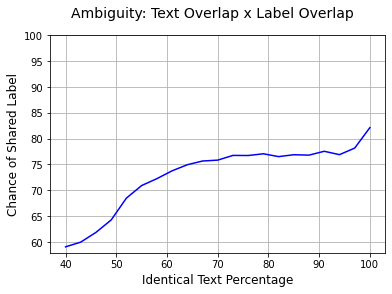

In [28]:
# Preparing a graph, relating the similarity of tweets to the likelihood
#of them being categorized the same way
Y_axis = []
X_axis = []
for percent in range(40,101, 3):
    diff_emo = 0
    dupes = 0
    for x in range(len(df)-2):
        tweet1 = df["processed_text"][x]
        tweet2  = df["processed_text"][x+1]
        emo1 = df["emotion"][x]
        emo2 = df["emotion"][x+1]
        ratio = fuzz.ratio(tweet1, tweet2)
        if (ratio >= percent) & (emo1 == emo2):
            dupes += 1
            diff_emo += 1
        elif ratio >= percent:
            dupes += 1
        else:
            pass
    X_axis.append(percent)
    Y_axis.append(100*(diff_emo/dupes))

plt.plot(X_axis, Y_axis, "b")
plt.grid(which="both")
plt.xlabel("Identical Text Percentage", fontsize = 12)
plt.ylabel("Chance of Shared Label", fontsize = 12)
plt.suptitle("Ambiguity: Text Overlap x Label Overlap", fontsize = 14)
plt.ylim(top = 100)

This was wildly unexpected. Even identical tweets are only matching about 82% of the time! How is that possible?

In [29]:
# Collecting just the identical ones
for x in range(len(df)-2):
    tweet1 = df["processed_text"][x]
    tweet2  = df["processed_text"][x+1]
    emo1 = df["emotion"][x]
    emo2 = df["emotion"][x+1]
    ratio = fuzz.ratio(tweet1, tweet2)
    if (ratio == 100) & (emo1 != emo2):
        print(tweet1) # Verifying that the text is the same
        print(tweet2)
        print(emo1) # Verifying that the emotions are different
        print(emo2)
        print(ratio)
        print("\n")

at sxsw apple schools the marketing experts link
at sxsw apple schools the marketing experts link
Positive
Not positive
100


does your smallbiz need reviews to play on google places we got an app for that link seo sxsw
does your smallbiz need reviews to play on google places we got an app for that link seo sxsw
Positive
Not positive
100


at sxsw apple schools the marketing experts link
at sxsw apple schools the marketing experts link
Not positive
Positive
100


mention google will connect the digital amp physical worlds through mobile link sxsw rt mention
mention google will connect the digital amp physical worlds through mobile link sxsw rt mention
Positive
Not positive
100


win free ipad from webdoc com sxsw rt
win free ipad from webdoc com sxsw rt
Not positive
Positive
100


rt mention what is going on at sxsw today share photos video with ireport link or through cnn iphone app
rt mention what is going on at sxsw today share photos video with ireport link or through cnn iphone ap

My first reaction to these identical tweets getting two different scores was to panic. But, looking at them more, I think that these are tweets that perhaps should have been labeled with "I can't tell", if only the raters were less confident in their own abilities. The fact that two different people (or the same person twice) rated them differently is a bit annoying. But I can see how this would happen.

To untangle this, I found a semi-arbitrary cutoff where any difference in categorization was likely to be because of the difference in text as opposed to a difference in interpretation. Anything more similar than that cutoff will be taken out of the population. Hopefully, this means my NLP algorithm will be dealing with less ambiguous data.

In [30]:
# Getting samples for tweets at various high similarity scores
for percent in range(80,96,2):
    counter = 0
    print("\n")
    print(percent)
    for x in range(len(df)-2):
        if counter == 5: # Taking no more than 5 pairs of tweets per %
            counter = 0
            break #
        else:
            tweet1 = df["processed_text"][x]
            tweet2  = df["processed_text"][x+1]
            emo1 = df["emotion"][x]
            emo2 = df["emotion"][x+1]
            ratio = fuzz.ratio(tweet1, tweet2)
            if (ratio == percent) & (emo1 != emo2):
                print(tweet1)
                print(tweet2)
                print("\n")
                counter += 1
            else:
                pass



80
40 of google maps usage is mobile now has 150 million mobile users sxsw via mention
40 of google maps usage is mobile wow mention sxsw via mention


rt mention quot google before you tweet is the new think before you speak quot belinsky of digital democracy sxsw 911tweets
rt mention quot google before you tweet quot is the new quot think before you speak quot mark belinsky sxsw


rt mention rt mention google set to launch new social network circles today at sxsw
rt mention rt mention google to launch social network circles at sxsw link who is excited




82
ûï mention apple store downtown austin open til midnight sxsw mention there is still time
ûï mention apple store downtown austin open til midnight sxsw any ipad2 left in stock


apple set to open popup shop in core of sxsw action link sxsw apple ipad retail
apple set to open popup shop in core of sxsw action link sxsw apple apple set to open popup sh link


rt mention apple popup store at sxsw link
rt mention apple popup store 

It seems like new useful information peters out in the high 80s with raw text. It's subjective, but that's what I have to go off of. 

But does that remain true if we remove all the stopwords and lemmatize the text? If stopwords are removed, that should mean that the more meaningful words are making up more of the differences between messages. So it's time to do that.

### Tokenize and Lemmatize

A new column out of processed_text so just the most popular (and hopefully useful) word pieces will be left behind. I left processed_text alone so I can still read something coherent.

First steps: setting up the regex filter and creating an empty column.

In [31]:
# Another filter from earlier in the course
pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
df["tokens"] = ""
for i in range(len(df)):
    df["tokens"][i] = nltk.regexp_tokenize(df["processed_text"][i], pattern)

Next, removing stopwords. I already jumped ahead and saw which words show up most often in the FreqDist, so I added those to the stopwords list at the end.

In [32]:
stopwords_list = stopwords.words("english")
stopwords_list += list(string.punctuation)
stopwords_list += [str(i) for i in range(10)]
stopwords_list += ["sxsw", "link", "mention"] #The top words by far

for i in range(len(df)):
    df["tokens"][i] = [w for w in df["tokens"][i] if w not in stopwords_list]

Now, to reduce each word to its lemma, if possible.

In [33]:
lemmatizer = WordNetLemmatizer()

In [34]:
for i in range(len(df)-1):
    new_sentence = []
    for word in df["tokens"][i]:
        new_sentence.append(lemmatizer.lemmatize(word))
    df["tokens"][i] = new_sentence

In [35]:
all_tokens = []
for i in range(len(df)-1):
    for w in df["tokens"][i]:
        all_tokens.append(w)

freq = FreqDist(all_tokens)
freq.most_common(6)

[('ipad', 2961),
 ('rt', 2935),
 ('google', 2616),
 ('apple', 2309),
 ('quot', 1657),
 ('iphone', 1559)]

I decided to leave "quot" and "rt" in case people link to things, quote people, or retweet more often based on a particular emotional reaction to those things.

Now how often do similar texts have different categories?

In [36]:
# Just like before, but more granularly
for percent in range(85,101):
    diff_emo = 0
    dupes = 0
    for x in range(len(df)-2):
        tweet1 = df["tokens"][x]
        tweet2  = df["tokens"][x+1]
        emo1 = df["emotion"][x]
        emo2 = df["emotion"][x+1]
        ratio = fuzz.ratio(tweet1, tweet2)
        if (ratio >= percent) & (emo1 == emo2):
            dupes += 1
            diff_emo += 1
        elif ratio >= percent:
            dupes += 1
        else:
            pass
    print(str(percent) + "%ers match " + str(diff_emo/dupes) + " of the time")

85%ers match 0.7779751332149201 of the time
86%ers match 0.7807971014492754 of the time
87%ers match 0.7844990548204159 of the time
88%ers match 0.7883495145631068 of the time
89%ers match 0.7814432989690722 of the time
90%ers match 0.7871396895787139 of the time
91%ers match 0.789838337182448 of the time
92%ers match 0.7878787878787878 of the time
93%ers match 0.7890173410404624 of the time
94%ers match 0.7917981072555205 of the time
95%ers match 0.7842465753424658 of the time
96%ers match 0.7887931034482759 of the time
97%ers match 0.791907514450867 of the time
98%ers match 0.8035714285714286 of the time
99%ers match 0.8035714285714286 of the time
100%ers match 0.8035714285714286 of the time


In [39]:
df["tokens"][0]

['wesley',
 'g',
 'iphone',
 'hr',
 'tweeting',
 'rise',
 'austin',
 'dead',
 'need',
 'upgrade',
 'plugin',
 'station']

Unfortunately, this seems to be about the same. Maybe a 1% improvement.

In [37]:
# Here are all the adjacent 89s for reference.
for x in range(len(df)-2):
    tweet1 = df["tokens"][x]
    tweet2  = df["tokens"][x+1]
    emo1 = df["emotion"][x]
    emo2 = df["emotion"][x+1]
    ratio = fuzz.ratio(tweet1, tweet2)
    if (ratio ==89) & (emo1 != emo2):
        print(tweet1)
        print(tweet2)
        print(emo1)
        print(emo2)
        print(ratio)
        print("\n")

['line', 'apple', 'store', 'ipad']
['line', 'apple', 'store', 'ipad', 'day']
Not positive
Positive
89


['apple', 'set', 'open', 'popup', 'shop', 'core', 'action', 'apple']
['apple', 'set', 'open', 'popup', 'shop', 'core', 'action', 'apple', 'ipad', 'retail']
Not positive
Positive
89


['google', 'map', 'usage', 'mobile', 'yowza']
['google', 'map', 'usage', 'mobile']
Positive
Not positive
89


['google', 'map', 'use', 'mobile']
['google', 'map', 'use', 'mobile', 'marissamayer']
Not positive
Positive
89


['rt', 'presentation', 'demonstrates', 'pause', 'video', 'new', 'video', 'player', 'pick', 'spot', 'ipad', 'app', 'tveverywhere']
['rt', 'preso', 'demonstrates', 'pause', 'video', 'new', 'video', 'player', 'amp', 'pick', 'spot', 'ipad', 'app', 'tveverywhere']
Positive
Not positive
89


['rt', 'new', 'ubersocial', 'iphone', 'app', 'store', 'includes', 'uberguide', 'got']
['rt', 'new', 'ubersocial', 'iphone', 'app', 'store', 'includes', 'uberguide', 'sponsored']
Positive
Not positive
89


A lot of the difference is in just a word or two. Sometimes it makes sense (adding "good" to a message makes it positive) and other times it's just a transposition of letters or adding a name. So at this % range there's a mix of reasons why messages are different. To be fair, I'll set the bar at 90%.

### Splitting the dataset
#### I am going to run an experiment: I'll train one model with the most "ambiguous" texts removed, and train one model without removing anything. My prediction is that the model that is trained without those edge cases will have an easier time differentiating one from another, even with a slightly smaller corpus to draw from.

Step 1: Identify the similar tweets and set their IDs aside.

Step 2: In the interim, find out how many words show up more than once. If there are at least a few thousand, then those I'll remove words that show up only once.

Step 3: Create a duplicate DF and remove the ambiguous tweets from just one of them.

In [38]:
# isolating ones with different emotions but high similarity
ambig_emo = []
for x in range(len(df)-2):
        tweet1 = df["tokens"][x]
        for y in range(len(df)-1):
            tweet2 = df["tokens"][y]
            ratio = fuzz.ratio(tweet1, tweet2)
            if ratio < 89:
                pass
            elif df["emotion"][x] == df["emotion"][y]:
                pass
            elif x==y:
                pass
            else:
                ambig_emo.append(x)
                ambig_emo.append(y)

KeyboardInterrupt: 

In [ ]:
# What fraction of my data is that?
print(len(set(ambig_emo)))
print(len(set(ambig_emo))/len(df))

That's almost 1/6th of my data. This definitely had me speculating that the models would have a pretty sizable difference in their performance, one way or the other.

In [ ]:
# How many words appear more than once?
single_words = 0
for i in list(freq.values()):
    if i == 1:
        single_words += 1

#The entire frequency distribution minus the words which only appear once.
print(len(freq)-single_words)

Intuition tells me that nearly 5000 words should be enough to work with, but I am out of my depth to make that judgment. It might not help that the tweets are so short, but that's a problem for another day.

In [ ]:
# Collecting the common words so I can filter everything else out
common_words = []
for item in freq.most_common(4806):
    common_words.append(item[0])

In [ ]:
# Editing the tokens column to only include those common words
for i in range(len(df)):
    df["tokens"][i] = [w for w in df["tokens"][i] if w in common_words]
    df["tokens"][i] = " ".join(df["tokens"][i])

And here it is, the mitosis event:

In [ ]:
# "sdf" will be the dataframe with edge cases removed. s = small/secondary
sdf = df.copy()

# Cutting the "ambiguous" ones
sdf.drop(sdf.index[ambig_emo], inplace = True)
sdf.reset_index(drop = True, inplace=True)

##### Note: In the next section, I will be adjusting the df and sdf in parallel, mirroring one another in the same cells. Whenever I am mirroring the code for the two, the duplicate code will be simply labeled with "#s"

# Building the Models

It hasn't yet been made explicitly clear to me when a simple Count Vectorizer is ever more effective at this task than a TF-IDF Vectorizer. So I will be testing them both. In addition, and partly to demonstrate to myself that these classifiers are indeed much more powerful than those I learned when I was even newer to the field, I'll also generate a Random Forest model.

If anything, having the third set of results can give me perspective into how much the difference there actually is between Count and TF IDF.

In [ ]:
#The tokens used by my untrimmed dataframe
df_tokens = []
for i in range(len(df)):
    df_tokens.append(df["tokens"][i])

#s    
sdf_tokens = []
for i in range(len(sdf)):
     sdf_tokens.append(sdf["tokens"][i])

In [ ]:
# Splitting the features in preparation for the train-test split
X = df_tokens
y = df[['emotion']]
#s
X_s = sdf_tokens
y_s = sdf[["emotion"]]

# Training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                 random_state=42)
#s
Xs_train, Xs_test, ys_train, ys_test = train_test_split(X_s, y_s,
                                                        random_state=4)

# Taking the training set and further splitting it into a secondary
#training set and a new validation set.

X_train2, X_test2, y_train2, y_test2 = train_test_split(X_train, y_train, 
                                              random_state=42)
#s
Xs_train2, Xs_test2, ys_train2, ys_test2 = train_test_split(Xs_train, 
                                                ys_train, random_state=4)

### Count Vectorizers

If my dataset was extremely large, I would have switched to a Hashing Vectorizer. At this size, performance shouldn't be affected noticeably.

In [ ]:
cv = CountVectorizer(max_features=4816)
#s
cvs = CountVectorizer(max_features=4816)

# Fit-transforming onto the validation set's training data
X_train2_vec = cv.fit_transform(X_train2)
#s
Xs_train2_vec = cvs.fit_transform(Xs_train2)

# Transforming the validation set
X_test2_vec = cv.transform(X_test2)
#s
Xs_test2_vec = cvs.transform(Xs_test2)

In [ ]:
#Initializing Naive Bayes classifiers
mnb_cv = MultinomialNB()
mnb_cv.fit(X_train2_vec, y_train2["emotion"].ravel())
#s
mnb_cvs = MultinomialNB()
mnb_cvs.fit(Xs_train2_vec, ys_train2["emotion"].ravel())

In [ ]:
#Getting an accuracy score for the first classifier...
y_hat_cv = mnb_cv.predict(X_test2_vec)
acc_cv = str(accuracy_score(y_test2, y_hat_cv))
print("accuracy 'cv' = " + acc_cv)

71.96% accuracy for the Count Vectorizer on the unchanged DF. This doesn't seem like a good result, considering the fact that this is only a little better than blindly guessing the majority class every time. 

In [ ]:
# The majority class is how big again?
y_test2.value_counts()[0]/len(y_test2)

Ouch. What does the confusion matrix look like?

In [ ]:
cm_cv = confusion_matrix(y_test2, y_hat_cv)
ConfusionMatrixDisplay(confusion_matrix=cm_cv, 
                       display_labels=mnb_cv.classes_).plot()

Recall for nonpositives is really good (over 80%!) but it is having a lot of trouble giving me a pool of likely-positive tweets to sift through.

Did the secondary DF fare better?

In [ ]:
ys_hat_cv = mnb_cvs.predict(Xs_test2_vec)
acc_cvs = str(accuracy_score(ys_test2, ys_hat_cv))
print("accuracy 'cvs'= " + acc_cvs)

In [ ]:
cm_cvs = confusion_matrix(ys_test2, ys_hat_cv)
ConfusionMatrixDisplay(confusion_matrix=cm_cvs, 
                       display_labels=mnb_cvs.classes_).plot()

Yes! All that work paid off. 2% is 2%.

### TF IDF Vectorizer

The score to beat is 73.9% accuracy.

In [ ]:
tf = TfidfVectorizer(max_features=4816, lowercase = False)
#s
tfs = TfidfVectorizer(max_features=4816, lowercase = False)

# Fit-transforming onto the validation set's training data
X_train2_tf_vec = tf.fit_transform(X_train2)
#s
Xs_train2_tf_vec = tfs.fit_transform(Xs_train2)

# Transforming the validation set
X_test2_tf_vec = tf.transform(X_test2)
#s
Xs_test2_tf_vec = tfs.transform(Xs_test2)

In [ ]:
mnb_tf = MultinomialNB()
mnb_tf.fit(X_train2_tf_vec, y_train2["emotion"].ravel())

y_hat_tf = mnb_tf.predict(X_test2_tf_vec)
acc_df = str(accuracy_score(y_test2, y_hat_tf))
print("accuracy, TF-IDF for df= " + acc_df)

In [ ]:
cm_tf = confusion_matrix(y_test2, y_hat_tf)
ConfusionMatrixDisplay(confusion_matrix=cm_tf, 
                       display_labels=mnb_tf.classes_).plot()

72.15% accuracy. Not quite good enough. Its recall for the minority class is downright horrible, too. I thought for sure the more sophisticated classifier would outperform here. Well, did it do any better with the shorter DF?

In [ ]:
mnb_tfs = MultinomialNB()
mnb_tfs.fit(Xs_train2_tf_vec, ys_train2["emotion"].ravel())

ys_hat_tf = mnb_tfs.predict(Xs_test2_tf_vec)
acc_sdf = str(accuracy_score(ys_test2, ys_hat_tf))
print("accuracy TF-IDF for 'sdf'= " + acc_sdf)

In [ ]:
cm_tfs = confusion_matrix(ys_test2, ys_hat_tf)
ConfusionMatrixDisplay(confusion_matrix=cm_tfs, 
                       display_labels=mnb_tfs.classes_).plot()

73.8%. At first this seemed like a virtual tie with the other classifier (73.9) but the TF-IDF vectorizers have been giving me just putrid recall numbers. I think that even if it had a slightly better accuracy score than the CVs, I'd still have to turn it away.

##### So the Count vectorizer on the secondary DF is the winner.

### Random Forest (for perspective)

As a completely new data scientist, I think it would be useful for my education to try an unrelated estimator so I can see just how much better the nltk estimators are at this job.

In [ ]:
#I did originally run this cell with a wider and more varied spread of params,
#and a cv value of 3. To save time rerunning repeatedly, I pared each down.

from sklearn.ensemble import RandomForestClassifier

param_grid = {
"n_estimators": [40, 75, 120],
"max_depth": [2, 4, 7],
"min_samples_split": [3, 5, 10],
"random_state": [1]}


rf = RandomForestClassifier()

rfs = RandomForestClassifier()

rf_grid = GridSearchCV(
    rf, param_grid=param_grid, cv = 2, 
    return_train_score=True).fit(X_train2_vec, y_train2["emotion"].ravel())

rfs_grid = GridSearchCV(
    rfs, param_grid=param_grid, cv = 2, 
    return_train_score=True).fit(Xs_train2_vec, ys_train2["emotion"].ravel())


In [ ]:
print("df best features = " + str(rf_grid.best_params_))
print("sdf best features = " + str(rfs_grid.best_params_))

In [ ]:
rf = RandomForestClassifier(n_estimators=120, 
                            max_depth= 7, min_samples_split= 10)

rf.fit(X_train2_vec, y_train2["emotion"].ravel())
y_hat = rf.predict(X_test2_vec)
print("original df accuracy score = " + str(accuracy_score(y_hat, y_test2)))


#s
rfs = RandomForestClassifier(n_estimators=40, 
                             max_depth= 7, min_samples_split= 3)

rfs.fit(Xs_train2_vec, ys_train2["emotion"].ravel())
ys_hat = rfs.predict(Xs_test2_vec)
print("sdf accuracy score = " + str(accuracy_score(ys_hat, ys_test2)))

As expected, the RF was easily outcompeted by the NLP-specific classifiers.

# Final Result

Here is the TF IDF classifier that we found before.

In [ ]:
tf_final = CountVectorizer(max_features=4816, lowercase = False)

final_train_vectors = tf_final.fit_transform(Xs_train)

final_test_vectors = tf_final.transform(Xs_test)

final_mnb = MultinomialNB()


final_mnb.fit(final_train_vectors, ys_train["emotion"].ravel())

y_hat_final = final_mnb.predict(final_test_vectors)
acc_final = str(accuracy_score(y_hat_final, ys_test))

print("final accuracy = " + acc_final)

In [ ]:
cm_final = confusion_matrix(ys_test, y_hat_final)
ConfusionMatrixDisplay(confusion_matrix=cm_final, 
                       display_labels=final_mnb.classes_).plot()

73.2% is a near-negligible drop off of only 0.7% compared to the training set. And just like the other CV-built models, this one has "decent" recall and precision for finding positive results, but nothing to write home about.

### Conclusion
Thankfully, my final model did almost exactly as well on the unseen data as it did on all of my trails. Still, this is far too close to the about 2/3s baseline that the majority class set for me.

I'm pretty sure I understand that a recommendation would be something like "find out what negative things happened at that year's festival" and the next steps are advice to the tech team about what could be done to improve the process

#### Recommendations: 
For future marketing, it may be helpful to know what pairs of words were most associated with positive experiences and hype going into the event. Most relevant in my opinion would be 'ipad' + 'app' (showing that people really do respond to platform exclusives) and 'marissa' 'mayer' (showing that she probably brings with her a lot of goodwill. Maybe bring her back for some announcements?)

Moving forward you should also broaden your focus to what people disliked about the event.

The most telling negatively associated pair of words was "google" + "circle". New social media enterprises generate more groans than interest.


#### The Next Steps:

Future processing should iterate to find the most accurate boundary between fuzzy tweets.

Tweets might not have enough information to generalize from. That, or they are so volatile thanks to the impact one word can have on so few characters. Either way, one should try to scrape data from social media apps with more long form engagement patterns.

I suspect that the data was soured by poor inter-rater reliability. If resources could be put into that I imagine that would be a big help.